# Regressão: Preveja consumo de combustível

O estudo de hoje é um problema de regressão, onde o objetivo é prever saídas (*outputs*) de um valor contínuo, como a probabilidade de algo acontecer ou o preço de algum produto.

Este estudo usa a base de dados [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) que possui dados para prever o consumo de combustível de automóveis no final de 1970. Para isso, é necessário que os dados sejam relacionados com o objetivo, nesse caso os dados são os valores de cilindos, peso, potência do motor e peso.

Usaremos a API [tf.keras](https://www.tensorflow.org/guide/keras?hl=pt-br).

## Importar as bibliotecas

In [1]:
# Importar as bibliotecas que usaremos
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Saber a versão do TensorFlow
print(tf.__version__)

2.8.2


## Base de dados Auto MPG

O conjunto de dados está disponível no site [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)

### Pegar os dados

Primeiramente, devemos baixar o conjunto de dados:

In [2]:
# Baixar a base de dados
dados_path = keras.utils.get_file('auto-mpg.data','http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')
dados_path

40960/30286 [========================================] - 0s 1us/step


'/root/.keras/datasets/auto-mpg.data'

Vamos importar os dados utilizando o **pandas**:

In [3]:
# Ajeitar os dados e importá-los
coluna_nomes = ['MPG', 'Cilindros', 'Quilometragem', 'Cavalos', 'Peso',
                'Aceleração', 'Ano/Modelo', 'Origem']
dados_bruto = pd.read_csv(dados_path,
                          names=coluna_nomes,
                          na_values='?',
                          comment='\t',
                          sep=' ',
                          skipinitialspace=True)
dados = dados_bruto.copy()
dados.tail()

,MPG,Cilindros,Quilometragem,Cavalos,Peso,Aceleração,Ano/Modelo,Origem
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Limpar os dados

Esse conjunto de dados possui alguns valores que são desconhecidos:

In [4]:
# Ver se há valores nulos
dados.isna().sum()

MPG              0
Cilindros        0
Quilometragem    0
Cavalos          6
Peso             0
Aceleração       0
Ano/Modelo       0
Origem           0
dtype: int64

Como valores nulos atrapalham o modelo, devemos retirar as linhas que possuem esse valor nulo:

In [5]:
# Retirar as linhas com valor nulo
dados = dados.dropna()

A coluna "Origem" é uma coluna categórica e não numérica. Precisamos convertê-la para *one-hot*:

In [6]:
# Retirar a coluna "Origem"
origem = dados.pop('Origem')

# Codificar a origem de cada automóvel por one-hot
dados['EUA'] = (origem == 1)*1.0
dados['Europa'] = (origem == 2)*1.0
dados['Japão'] = (origem == 3)*1.0

# Ver como os dados estão dispostos
dados.tail()

,MPG,Cilindros,Quilometragem,Cavalos,Peso,Aceleração,Ano/Modelo,EUA,Europa,Japão
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Separar os dados de treino e teste

Agora precisamos separar os dado para o treino e para o teste. Vamos utilizar o conjunto de teste no final da anáise do modelo:

In [7]:
# Separar os dados em treino e teste
dados_treino = dados.sample(frac=0.8, random_state=0)
dados_teste = dados.drop(dados_treino.index)

### Inspecionar os dados

Vejamos como está a distribuição de algumas colunas do conjunto de treino:

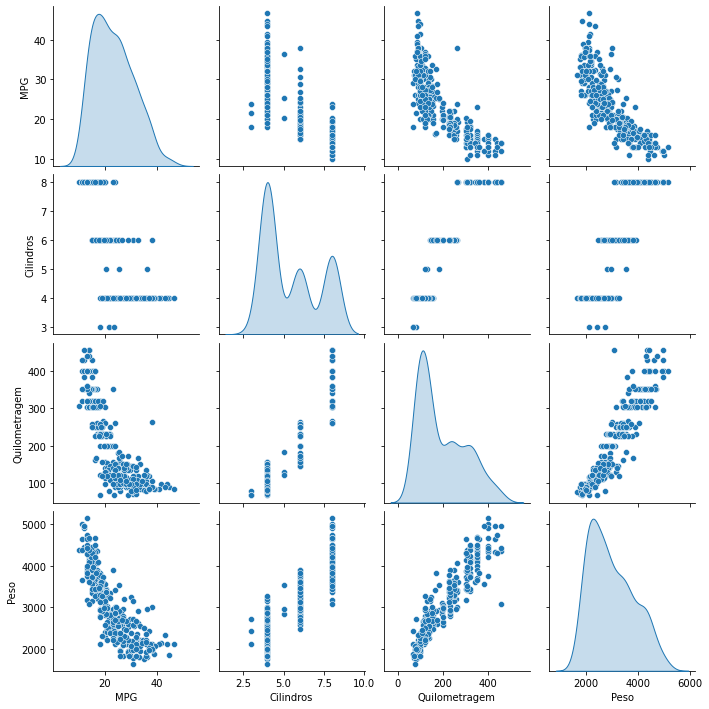

In [8]:
# Criar uma plotagem de comparação
sns.pairplot(dados_treino[['MPG', 'Cilindros', 'Quilometragem', 'Peso']], diag_kind='kde')

Vejamos a visão geral das estatísticas:

In [9]:
# Estatísticas gerais do conjunto de treino
status_treino = dados_treino.describe()
status_treino.pop('MPG')
status_treino = status_treino.transpose()
status_treino

,count,mean,std,min,25%,50%,75%,max
Cilindros,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Quilometragem,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Cavalos,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Peso,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Aceleração,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Ano/Modelo,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
EUA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europa,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japão,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Separar as features de labels

Vamos separar o valor que queremos (*label*) das *features*. Essa label é o valor no qual o modelo é treinado para prever:

In [10]:
# Retirar a coluna com os dados que será o alvo do modelo
labels_treino = dados_treino.pop('MPG')
labels_teste = dados_teste.pop('MPG')

### Normlaizar os dados

Observe a célula com o `status_treino` e perceba o quão diferente é a variação de cada feature. Um passo interessante de realizar é normalizar as featres que usam diferentes escalas e intervalos. Apesar do modelo conseguir trabalhar sem a normalização, isso torna o treino mais difícil, deixando o modelo à mercê da unidade escolhida de entrada:

In [11]:
# Normalizar os dados
def norm(x):
  return (x - status_treino['mean']) / status_treino['std']

# Normalizar os dados de treino e de teste
dados_treino_norm = norm(dados_treino)
dados_teste_norm = norm(dados_teste)

Entregaremos ao modelo os dados normalizados.

## O modelo

### Construindo o modelo

Agora chegou a parte mais legal do estudo: montar o modelo! Usaremos o modelo `Sequential` com duas camadas *densely connected*, e a camada de saída que nor entrega a saída. As estapas de construção do modelo são agrupados em um única função `construcao_modelo`, umavez qe criaremos um modelo posteriormente:

In [12]:
# Construir o modelo
def construcao_modelo():
  modelo = keras.Sequential([
                             layers.Dense(64,
                                          activation='relu',
                                          input_shape=[len(dados_treino.keys())]),
                             layers.Dense(64, activation='relu'),
                             layers.Dense(1)
  ])
  
  otimizador = tf.keras.optimizers.RMSprop(0.001)

  modelo.compile(loss='mse',
                 optimizer=otimizador,
                 metrics=['mae', 'mse'])
  
  return modelo

In [13]:
modelo = construcao_modelo()

### Examinar o modelo

Usaremos o método `summary` para que possamos acessar o sumário do modelo:

In [14]:
# Analisar o sumário do modelo
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Agora testaremos o modelo. Usaremos um lote de 10 exemplos do conjunto de treino e usaremos o método `predict` nesses exemplos:

In [15]:
# Prever os 10 primeiros exemplos
lote_exemplo = dados_treino_norm[:10]
resultado_exemplo = modelo.predict(lote_exemplo)
resultado_exemplo

array([[ 0.25256306],
       [ 0.05145149],
       [ 0.47968897],
       [ 0.48149285],
       [ 0.21701753],
       [ 0.06009827],
       [ 0.24058867],
       [ 0.42446542],
       [-0.03808679],
       [ 0.06613487]], dtype=float32)

Ao que parece, o modelo está funcionando e retorna os dados do modo esperado, ou seja, com os dados normalizados.

### Treinar o modelo

Treinaremos o modelo com 1000 *epochs*, gravando a acurácia do treino e da validação em um objeto `historia`:

In [16]:
# Treinar o modelo
class PrintPonto(keras.callbacks.Callback):
  """Mostrar o progresso do treino
  imprimindo um único ponto para cada época completada"""
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
      print('')
    print('.', end='')

EPOCAS = 1000

historia = modelo.fit(
    dados_treino_norm,
    labels_treino,
    epochs=EPOCAS,
    validation_split=0.2,
    verbose=0,
    callbacks=[PrintPonto()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Vamos visualizar o progresso do modelo usando os estados armaznados no objeto `historia`:

In [17]:
# Progresso do modelo
hist = pd.DataFrame(historia.history)
hist['epoch'] = historia.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.858810,1.037703,2.858810,8.191575,2.101862,8.191575,995
996,2.839416,1.024252,2.839416,8.780148,2.187976,8.780148,996
997,2.748429,1.035167,2.748429,9.186595,2.260348,9.186595,997
998,2.687892,1.002269,2.687892,8.441097,2.115659,8.441097,998
999,2.881615,1.024709,2.881615,8.836678,2.282211,8.836678,999


Vejamos agora em uma plotagem esses dados:

In [20]:
# Criar a função de plotagem
def plot_historia(historia):
  hist = pd.DataFrame(historia.history)
  hist['epoch'] = historia.epoch

  # Plotagem de MAE
  plt.figure()
  plt.xlabel('Épocas')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'],
           hist['mae'],
           label='Erro do treino')
  plt.plot(hist['epoch'],
           hist['val_mae'],
           label='Erro da validação')
  plt.ylim([0, 5])
  plt.legend()

  # Plotagem de MSE
  plt.figure()
  plt.xlabel('Épocas')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'],
           hist['mse'],
           label='Erro do treino')
  plt.plot(hist['epoch'],
           hist['val_mse'],
           label='Erro da validação')
  plt.ylim([0, 20])
  plt.legend()

  plt.show()

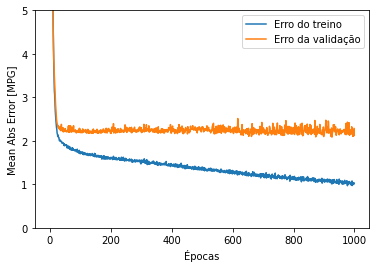

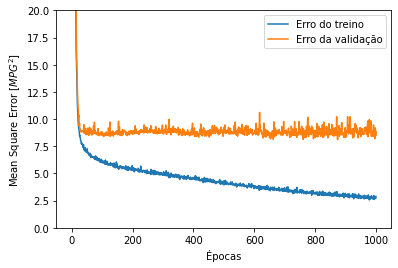

In [21]:
# Plotar o gráfico
plot_historia(historia)

Os gráficos acima mostrar que o modelo melhorou um pouco, mostrando que o erros de validação começa a diminuir após 100 épocas. Vamos atualizar o `modelo.fit()` para que pare o treinamento de modo automático quando a pontuação de validação não aumentar mais. Usaremos a função `EarlyStopping` (para mais informaçoes clique [aqui](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping))de `keras.callbacks` que testa a condição do treino a cada época. Se um grupo de épocas continua sem melhoras, o treino parará automaticamente:


.........................................................................................

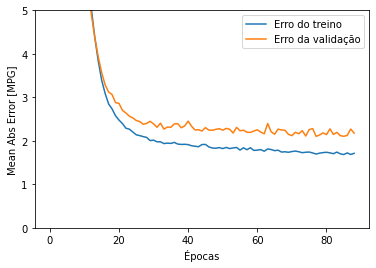

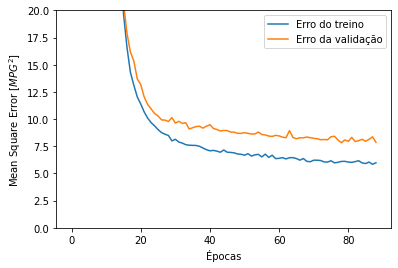

In [22]:
# Para o treinamento quando a pontuação d avalidação não aumentar mais
modelo = construcao_modelo()

# O parâmetro "patience" é a quantidade de épocas para checar as melhoras
parada = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Treinar o novo modelo
historia = modelo.fit(dados_treino_norm,
                      labels_treino,
                      epochs=EPOCAS,
                      validation_split=0.2,
                      verbose=0,
                      callbacks=[parada, PrintPonto()])

# Plotar os gráficos
plot_historia(historia)

O gráfico mostra que no conjunto de validação, a média de erro é próximo de 2. Mas isso é bom? Para saber se é bom é necessário que haja um referencial.

Vamos analisar o quão bem o modelo generaliza com os dados de teste (dados que ele nunca viu). Isso diz quão bem podemos esperar que o modelo acerte com dados da vida real:

In [23]:
# Saber o quão bem o modelo generaliza
loss, mae, mse = modelo.evaluate(dados_teste_norm,
                                 labels_teste,
                                 verbose=2)
print(f'''Função de perda: {loss:.2f}
Média dos erros absolutos: {mae:.2f}
Erro quadrático médio: {mse:.2f}''')

3/3 - 0s - loss: 5.4190 - mae: 1.7753 - mse: 5.4190 - 33ms/epoch - 11ms/step
Função de perda: 5.42
Média dos erros absolutos: 1.78
Erro quadrático médio: 5.42


### Fazer predições

Por fim, vamos prever os valores de MPG usando o conjunto de teste:

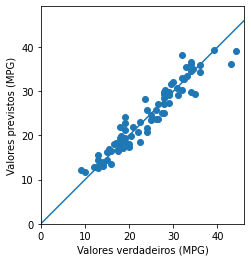

In [29]:
# Prever os valores
previsao_teste = modelo.predict(dados_teste_norm).flatten()

# Mostrar o gráfico de previsão
plt.scatter(labels_teste, previsao_teste)
plt.xlabel('Valores verdadeiros (MPG)')
plt.ylabel('Valores previstos (MPG)')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Parece que o nosso modelo prevê razoavelmente bem. Vejamos a distribuição dos erros:

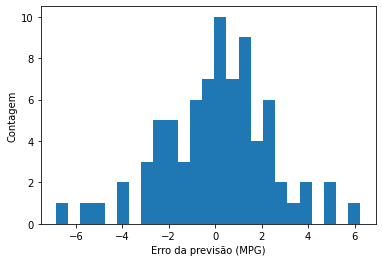

In [30]:
# Plotar a distribuição dos erros
erro = previsao_teste - labels_teste
plt.hist(erro, bins=25)
plt.xlabel('Erro da previsão (MPG)')
_ = plt.ylabel('Contagem')

Não é lá aquela gaussiana por ter poucos dados como exemplo.

## Conclusão

Este estudo mostrou alguma técnicas para lidar com problemas de regressão:

- Erro quadrático médio (MSE) é uma função comum de loss usada para problemas de regressão.

- De modo similar a MSE, usamos também a média dos erros absolutos (MAE).

- Quando o dados de entrada possui features com diferentes intervalos, cada feature deve ser escalada para o mesmo intervalo, ou seja, devemos normalizar os dados.

- Se não existir muitos dados de treino, uma técnica é escolher uma pequena rede com poucas camadas para evitar o **overfitting**.

- A parada antecipada do modelo é um boa técnica para evitar o **overfitting**.